## Three-step imputation of missing values in condition monitoring datasets
A paper by Hang Liu, Youyuan Wang, and WeiGen Chen.
Published on The Institution of Engineering and Technology Journals

This notebook is a Python Implementation of the three-step imputation method for missing values in time series datasets.

In [86]:
import os, shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from glob import glob
from tabulate import tabulate

In [ ]:
# Creating data and output directories
os.mkdir('data/')
os.mkdir('output/')

In [2]:
# Reading original datasets
paths = glob('data/*.csv')
paths

['data/PM25_2020.csv',
 'data/PM25_2017.csv',
 'data/PM25_2019.csv',
 'data/PM25_2018.csv',
 'data/PM25_2021.csv',
 'data/PM25_2016.csv']

In [3]:
# Reading datasets
datasets = {}
for path in paths:
  datasets[str(path[5:-4])] = pd.read_csv(path)
  
datasets_list = sorted(list(datasets.keys()))
datasets_list

['PM25_2016', 'PM25_2017', 'PM25_2018', 'PM25_2019', 'PM25_2020', 'PM25_2021']

In [4]:
# Dataset dimensions
for dataset in datasets_list:
  print(f"{dataset} dim: {datasets[dataset].shape}")

PM25_2016 dim: (529763, 14)
PM25_2017 dim: (606525, 14)
PM25_2018 dim: (557717, 14)
PM25_2019 dim: (566637, 14)
PM25_2020 dim: (564130, 14)
PM25_2021 dim: (869059, 11)


In [5]:
# Summary statistics
for dataset in datasets_list:
  print(f"Summary statistics for {dataset}")
  summary_df = {}
  summary_df['Variable'] = []
  summary_df['Uniques'] = []
  summary_df['Missing'] = []
  summary_df['Min'] = []
  summary_df['Max'] = []
  summary_df['Mean'] = []

  for column in datasets[dataset].columns:
    summary_df['Variable'].append(column)
    uniques = len(pd.unique(datasets[dataset][column]))
    summary_df['Uniques'].append(uniques)
    missing = sum(datasets[dataset][column].isna())
    missing_pct = missing / datasets[dataset].shape[0] * 100
    if missing:
      summary_df['Missing'].append(f"{missing_pct:.2f} %")
    else:
      summary_df['Missing'].append('-')
    if datasets[dataset][column].values.dtype in ['float64', 'int64'] and 'ID' not in column:
      summary_df['Min'].append(round(datasets[dataset][column].min(), 3))
      summary_df['Max'].append(round(datasets[dataset][column].max(), 3))
      summary_df['Mean'].append(round(datasets[dataset][column].mean(), 3))
    else:
      summary_df['Min'].append('-')
      summary_df['Max'].append('-')
      summary_df['Mean'].append('-')

  print(tabulate(pd.DataFrame(summary_df), headers = "keys", tablefmt="psql") + '\n')

Summary statistics for PM25_2016
+----+-------------------+-----------+-----------+--------+---------+--------+
|    | Variable          |   Uniques | Missing   | Min    | Max     | Mean   |
|----+-------------------+-----------+-----------+--------+---------+--------|
|  0 | DATE_PST          |      8784 | -         | -      | -       | -      |
|  1 | DATE              |       366 | -         | -      | -       | -      |
|  2 | TIME              |        24 | -         | -      | -       | -      |
|  3 | STATION_NAME      |        63 | -         | -      | -       | -      |
|  4 | STATION_NAME_FULL |        63 | -         | -      | -       | -      |
|  5 | EMS_ID            |        63 | -         | -      | -       | -      |
|  6 | NAPS_ID           |        39 | -         | -      | -       | -      |
|  7 | RAW_VALUE         |    298200 | 6.06 %    | -0.137 | 605.228 | 5.508  |
|  8 | ROUNDED_VALUE     |      1020 | 6.06 %    | -0.1   | 605.2   | 5.508  |
|  9 | UNIT        

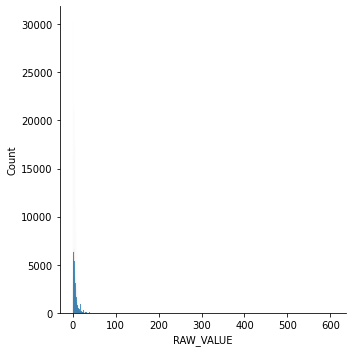

In [6]:
# Univariate outlier detection
sns.displot(datasets['PM25_2016']['RAW_VALUE'])

Cutoff at RAW_VALUE: 28.349 for percentile: 0.99


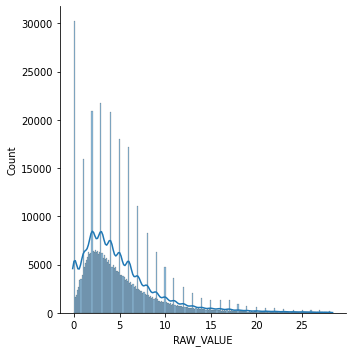

In [7]:
# Distribution plot on percentile threshold
percentile = 0.99

quantile = datasets['PM25_2016']['RAW_VALUE'].quantile(percentile)
print(f"Cutoff at RAW_VALUE: {quantile:.3f} for percentile: {percentile}")
sns.displot(datasets['PM25_2016'][datasets['PM25_2016']['RAW_VALUE'] < quantile]['RAW_VALUE'],
            kde = True)
plt.show()

Investigating threshold at > 300

reference: https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm25-particles-in-the-air

In [8]:
# Investigating threshold at raw value > 300
threshold = 300

for dataset in datasets_list:
  print(f"Subset of {dataset} at RAW_VALUE > {threshold}")
  try:
    subset = datasets[dataset][datasets[dataset]['RAW_VALUE'] > threshold][['DATE_PST', 'STATION_NAME', 'RAW_VALUE', 'REGION']]
    print(f"Subset size: {len(subset)} ({len(subset)/len(datasets[dataset]) * 100:.3f} %)")
    print(tabulate(subset, headers = "keys", tablefmt="psql") + '\n')
  except KeyError:
    pass

Subset of PM25_2016 at RAW_VALUE > 300
Subset size: 19 (0.004 %)
+--------+------------------+----------------+-------------+--------------------+
|        | DATE_PST         | STATION_NAME   |   RAW_VALUE | REGION             |
|--------+------------------+----------------+-------------+--------------------|
| 502807 | 2016-12-06 21:00 | Valemount      |     390.475 | 07 - Omineca-Peace |
| 502808 | 2016-12-06 22:00 | Valemount      |     499.013 | 07 - Omineca-Peace |
| 502809 | 2016-12-06 23:00 | Valemount      |     352.349 | 07 - Omineca-Peace |
| 502810 | 2016-12-07 00:00 | Valemount      |     345.078 | 07 - Omineca-Peace |
| 502811 | 2016-12-07 01:00 | Valemount      |     605.227 | 07 - Omineca-Peace |
| 502812 | 2016-12-07 02:00 | Valemount      |     432.655 | 07 - Omineca-Peace |
| 502813 | 2016-12-07 03:00 | Valemount      |     315.796 | 07 - Omineca-Peace |
| 502818 | 2016-12-07 08:00 | Valemount      |     374.959 | 07 - Omineca-Peace |
| 502819 | 2016-12-07 09:00 | Val

In [9]:
# Unique stations
stations = []
for dataset in datasets_list:
  for station in pd.unique(datasets[dataset]['STATION_NAME']):
    if station not in stations:
      stations.append(station)

print(f"Total unique stations: {len(stations)}")

Total unique stations: 87


In [10]:
# Unique regions
regions = []
for dataset in datasets_list:
  try:
    for region in pd.unique(datasets[dataset]['REGION']):
      if region not in regions:
        regions.append(region)
  except KeyError:
    pass

print(f"Total unique regions: {len(regions)}")

Total unique regions: 7


In [11]:
# Unique stations per region
stations_per_region = {}
print("Unique stations per region")
for dataset in datasets_list:
  try:
    stations_per_region[dataset[-4:]] = datasets[dataset].groupby('REGION')['STATION_NAME'].nunique()
  except KeyError:
    pass

print(tabulate(pd.concat(stations_per_region, axis = 1), headers = "keys", tablefmt="psql"))

Unique stations per region
+------------------------+--------+--------+--------+--------+--------+
| REGION                 |   2016 |   2017 |   2018 |   2019 |   2020 |
|------------------------+--------+--------+--------+--------+--------|
| 01 - Vancouver Island  |     11 |     12 |     13 |     11 |     11 |
| 02 - Lower Mainland    |     27 |     27 |     27 |     25 |     25 |
| 03 - Southern Interior |      5 |      5 |      5 |      7 |      3 |
| 04 - Kootenay          |      3 |      4 |      4 |      4 |      4 |
| 05 - Cariboo           |      2 |      2 |      2 |      2 |      3 |
| 06 - Skeena            |     10 |     10 |      8 |      9 |      9 |
| 07 - Omineca-Peace     |      5 |     11 |      9 |      8 |      9 |
+------------------------+--------+--------+--------+--------+--------+


In [12]:
# Aggregating datasets on region and by mean daily raw value accross stations
for dataset in datasets_list:
  try:
    grouped = datasets[dataset].groupby(['REGION', 'DATE']).mean().reset_index()
  except KeyError:
    pass
  
  # Filtering out unwanted columns
  datasets[f"{dataset}_AGG"] = grouped[['REGION', 'DATE', 'RAW_VALUE']]
  print(f"{dataset}_AGG dim: {datasets[f'{dataset}_AGG'].shape}")

PM25_2016_AGG dim: (2562, 3)
PM25_2017_AGG dim: (2555, 3)
PM25_2018_AGG dim: (2555, 3)
PM25_2019_AGG dim: (2555, 3)
PM25_2020_AGG dim: (2562, 3)
PM25_2021_AGG dim: (2562, 3)


In [13]:
# Time Series relationship subset plot function
def plot_ts(data, date, value, value_label, subset,
            col_wrap = 1, height = 3, aspect = 4):
  # Seaborn relplot
  grid = sns.relplot(data = data, x = date, y = value,
                    col = subset, hue = subset,
                    kind = 'line', palette = 'dark:salmon_r',
                    linewidth = 3, zorder = 5,
                    col_wrap = col_wrap, height = height,
                     aspect = aspect, legend = False)

  # Semantic foreground plot of subsets
  for time, ax in grid.axes_dict.items():
    ax.text(.1, .85, time,
            transform = ax.transAxes, fontsize = 12, fontweight = "bold")
    sns.lineplot(data = data, x = date, y = value,
                units = subset, estimator = None, color = ".7",
                linewidth = 1, ax = ax)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
  ax.tick_params(labelsize = 12)
  grid.set_titles('')
  grid.set_axis_labels('', value_label)
  grid.tight_layout()

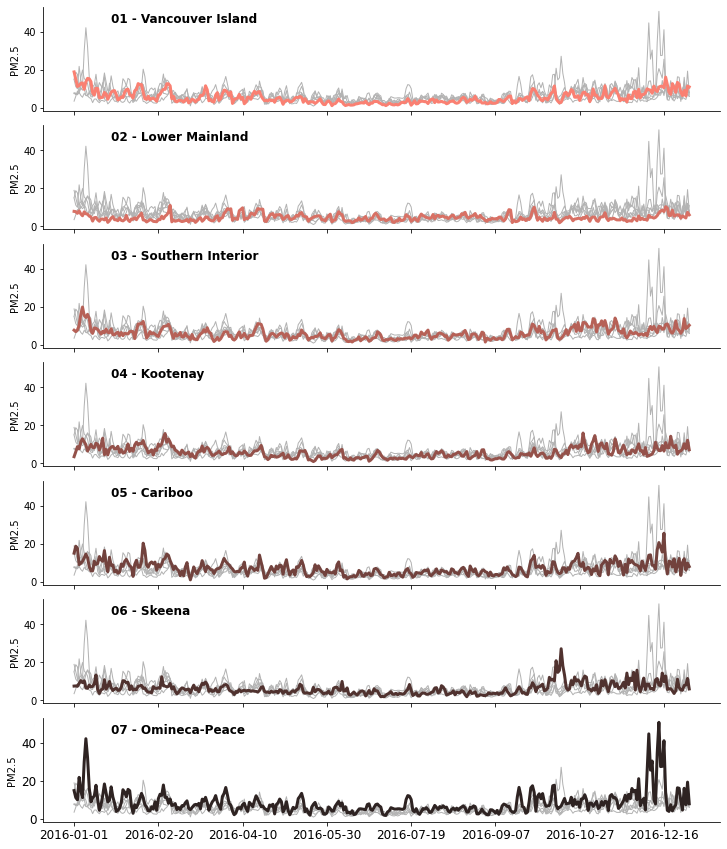

In [14]:
# Plotting aggregated 2016 dataset
plot_ts(data = datasets['PM25_2016_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

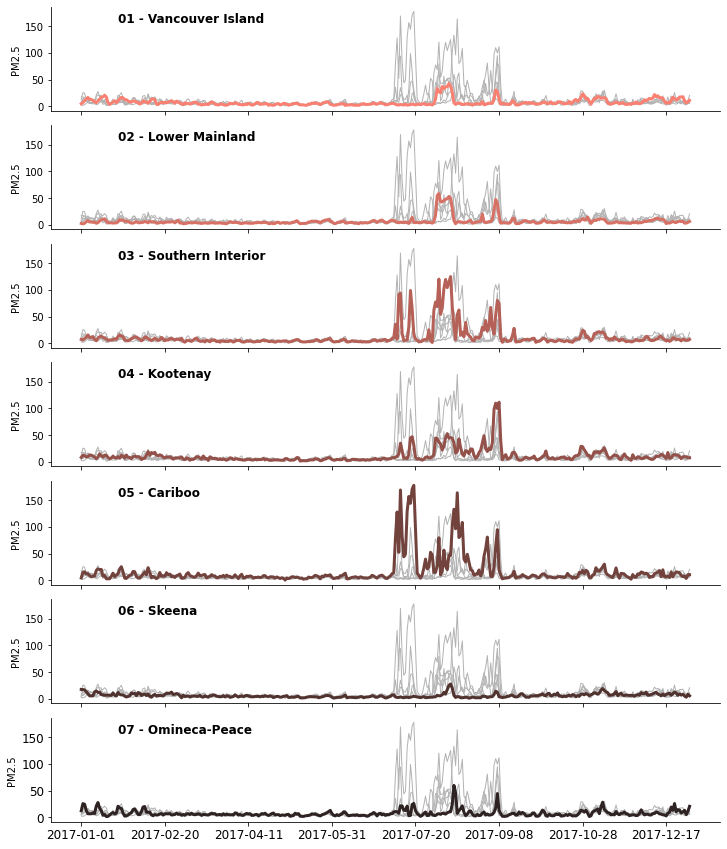

In [15]:
# Plotting aggregated 2017 dataset
plot_ts(data = datasets['PM25_2017_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

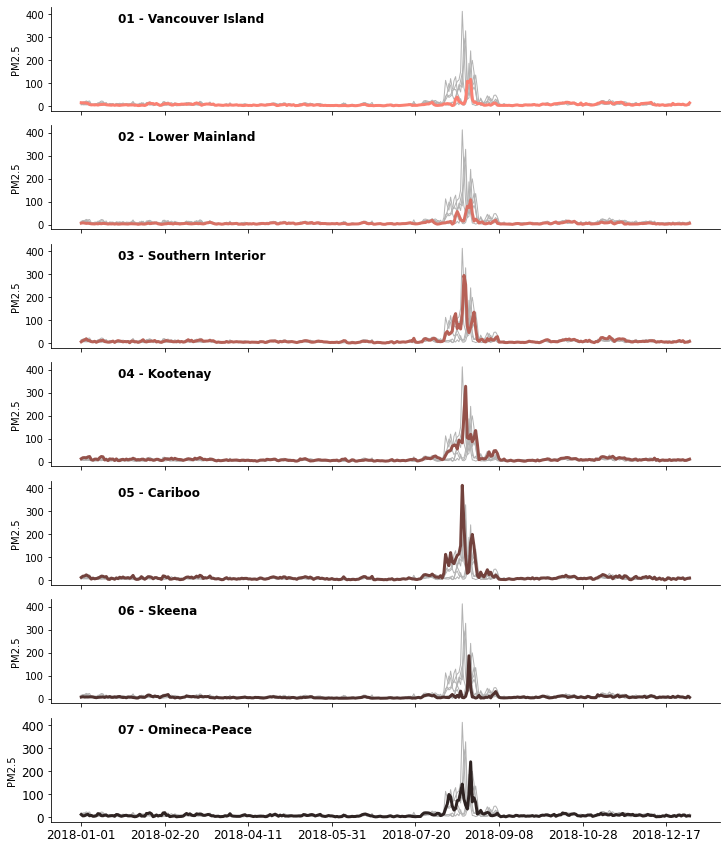

In [16]:
# Plotting aggregated 2018 dataset
plot_ts(data = datasets['PM25_2018_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

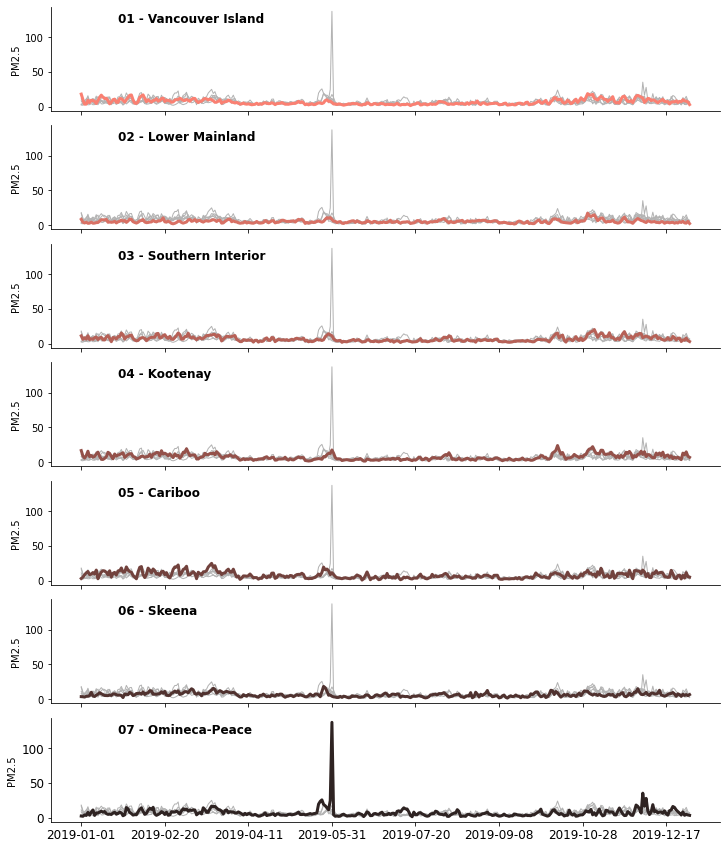

In [17]:
# Plotting aggregated 2019 dataset
plot_ts(data = datasets['PM25_2019_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

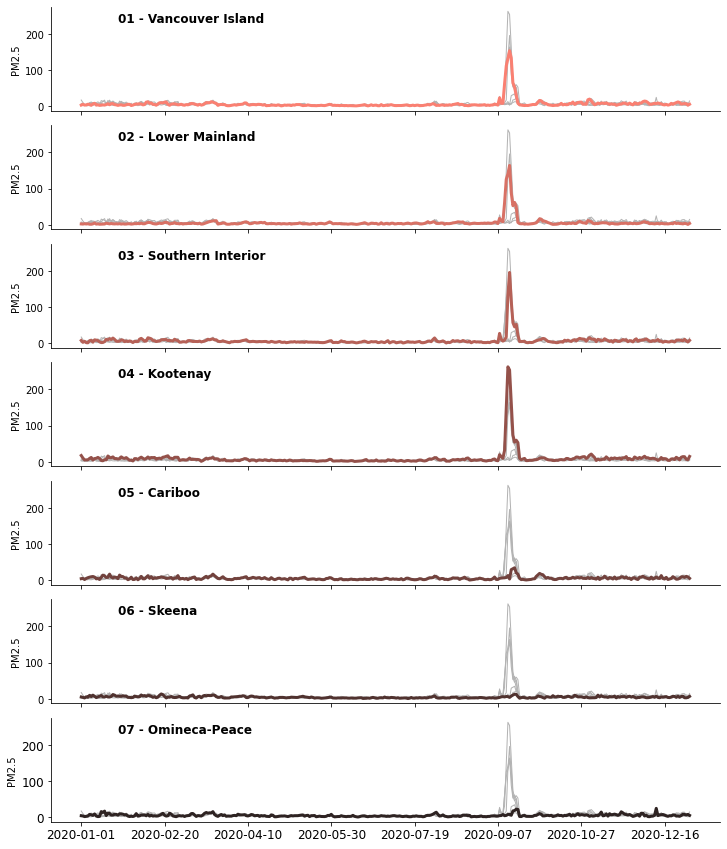

In [18]:
# Plotting aggregated 2020 dataset
plot_ts(data = datasets['PM25_2020_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

In [19]:
# Removing outliers at threshold cutoff
threshold = 300

for dataset in datasets_list:
  try:
    subset = datasets[dataset][datasets[dataset]['RAW_VALUE'] < threshold]
    grouped_subset = subset.groupby(['REGION', 'DATE']).mean().reset_index()
  except KeyError:
    pass
  
  # Filtering out unwanted columns
  datasets[f"{dataset}_CLEAN-T_AGG"] = grouped_subset[['REGION', 'DATE', 'RAW_VALUE']]
  print(f"{dataset}_CLEAN-T_AGG dim: {datasets[f'{dataset}_CLEAN-T_AGG'].shape}")

PM25_2016_CLEAN-T_AGG dim: (2562, 3)
PM25_2017_CLEAN-T_AGG dim: (2555, 3)
PM25_2018_CLEAN-T_AGG dim: (2555, 3)
PM25_2019_CLEAN-T_AGG dim: (2555, 3)
PM25_2020_CLEAN-T_AGG dim: (2562, 3)
PM25_2021_CLEAN-T_AGG dim: (2562, 3)


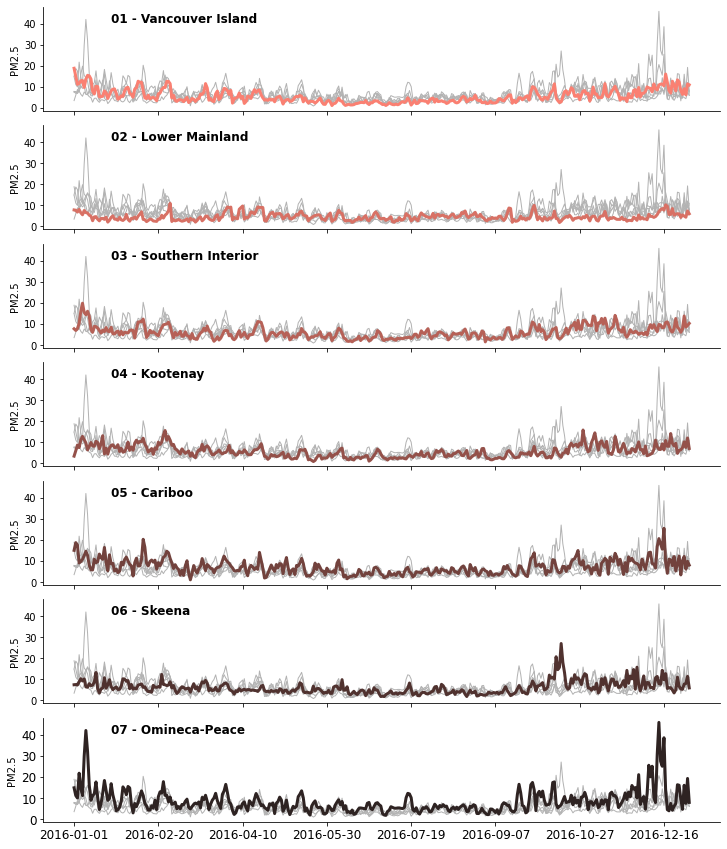

In [20]:
# Plotting threshold cleaned aggregated 2016 dataset
plot_ts(data = datasets['PM25_2016_CLEAN-T_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

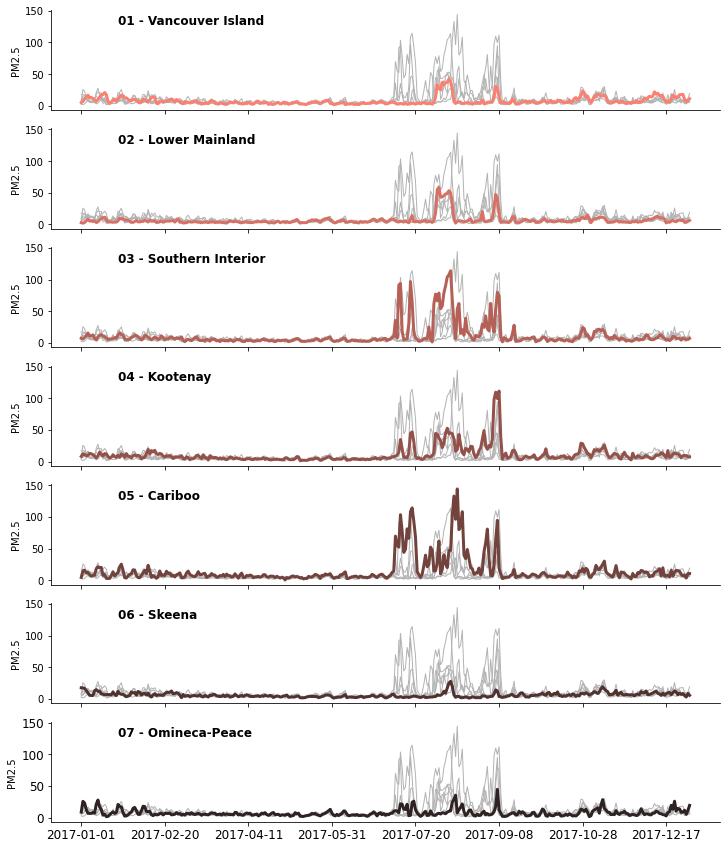

In [21]:
# Plotting threshold cleaned aggregated 2017 dataset
plot_ts(data = datasets['PM25_2017_CLEAN-T_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

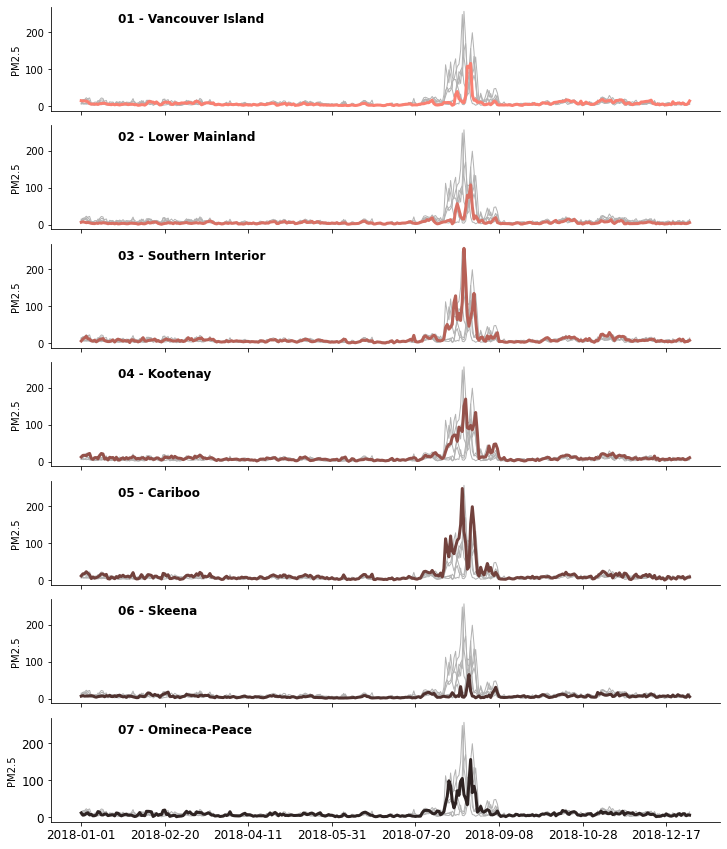

In [22]:
# Plotting threshold cleaned aggregated 2018 dataset
plot_ts(data = datasets['PM25_2018_CLEAN-T_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

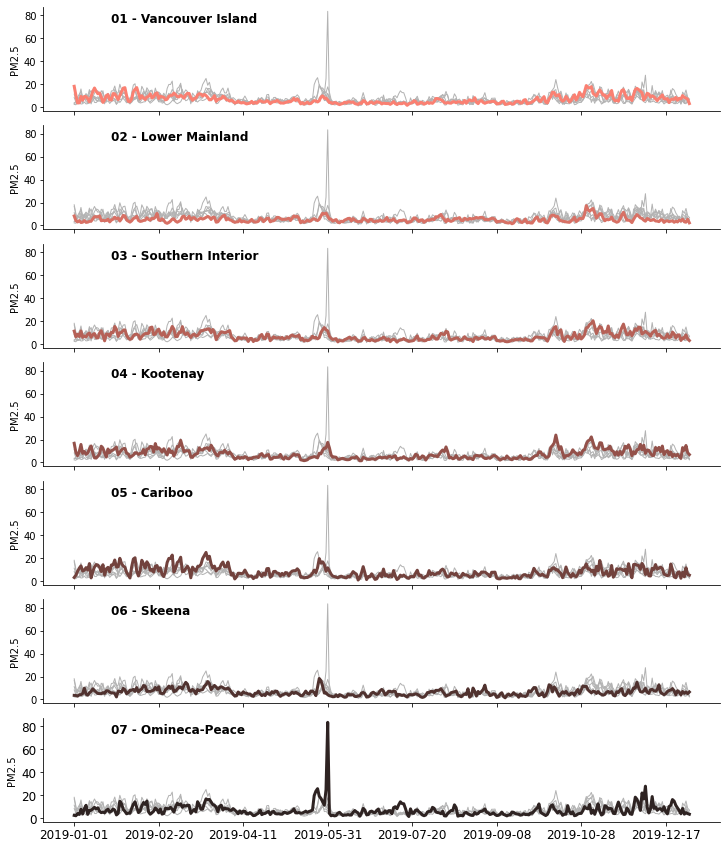

In [23]:
# Plotting threshold cleaned aggregated 2019 dataset
plot_ts(data = datasets['PM25_2019_CLEAN-T_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

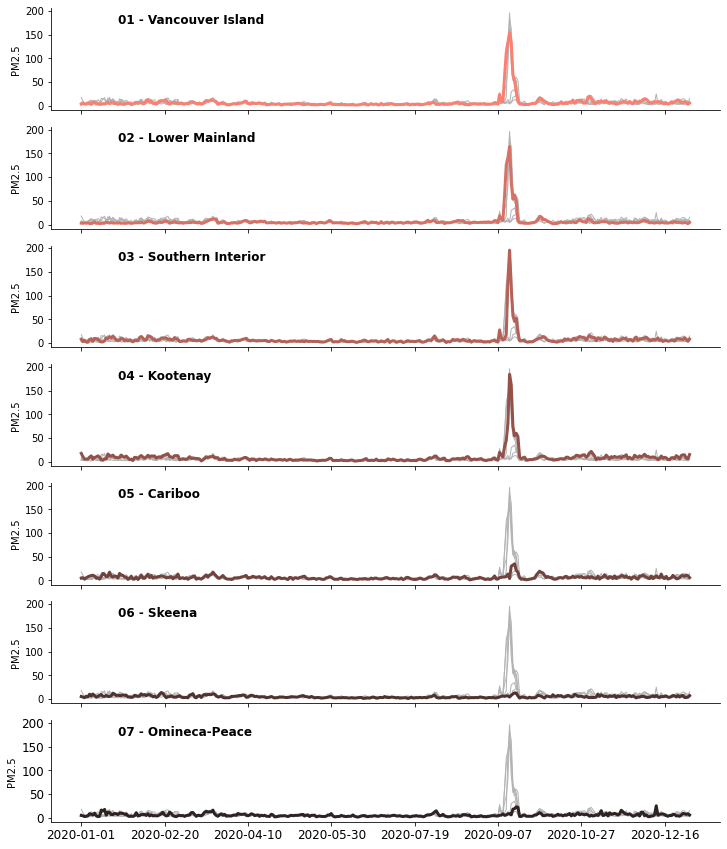

In [24]:
# Plotting threshold cleaned aggregated 2020 dataset
plot_ts(data = datasets['PM25_2020_CLEAN-T_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

In [25]:
# Removing outliers at top percentile cutoff
percentile = 0.99

for dataset in datasets_list:
  try:
    quantile = datasets[dataset]['RAW_VALUE'].quantile(percentile)
    subset = datasets[dataset][datasets[dataset]['RAW_VALUE'] < quantile]
    grouped_subset = subset.groupby(['REGION', 'DATE']).mean().reset_index()
  except KeyError:
    pass
  
  # Filtering out unwanted columns
  datasets[f"{dataset}_CLEAN-P_AGG"] = grouped_subset[['REGION', 'DATE', 'RAW_VALUE']]
  print(f"{dataset}_CLEAN-P_AGG dim: {datasets[f'{dataset}_CLEAN-P_AGG'].shape}")

PM25_2016_CLEAN-P_AGG dim: (2562, 3)
PM25_2017_CLEAN-P_AGG dim: (2554, 3)
PM25_2018_CLEAN-P_AGG dim: (2551, 3)
PM25_2019_CLEAN-P_AGG dim: (2555, 3)
PM25_2020_CLEAN-P_AGG dim: (2558, 3)
PM25_2021_CLEAN-P_AGG dim: (2558, 3)


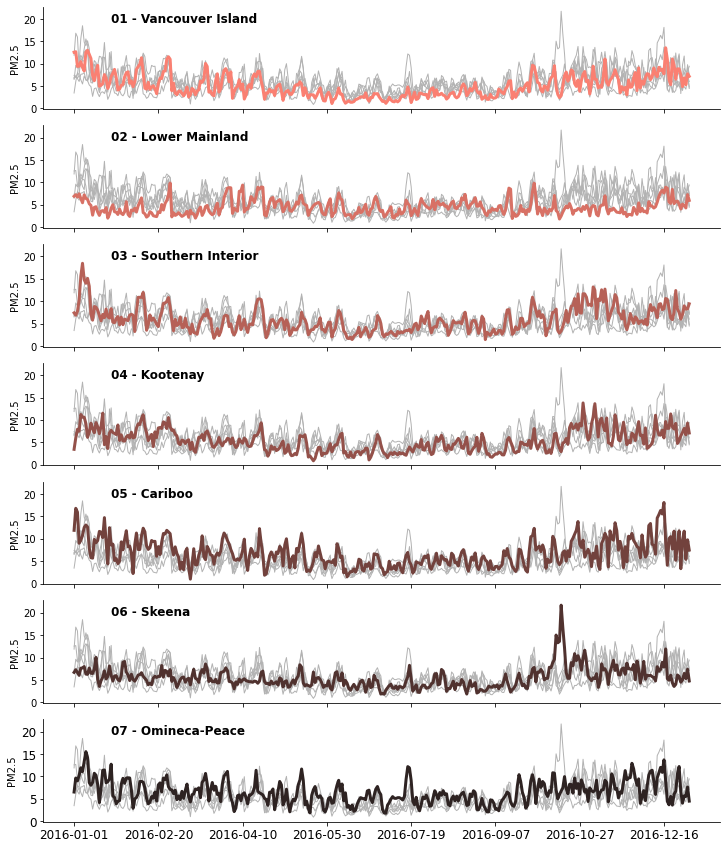

In [26]:
# Plotting percentile cleaned aggregated 2016 dataset
plot_ts(data = datasets['PM25_2016_CLEAN-P_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

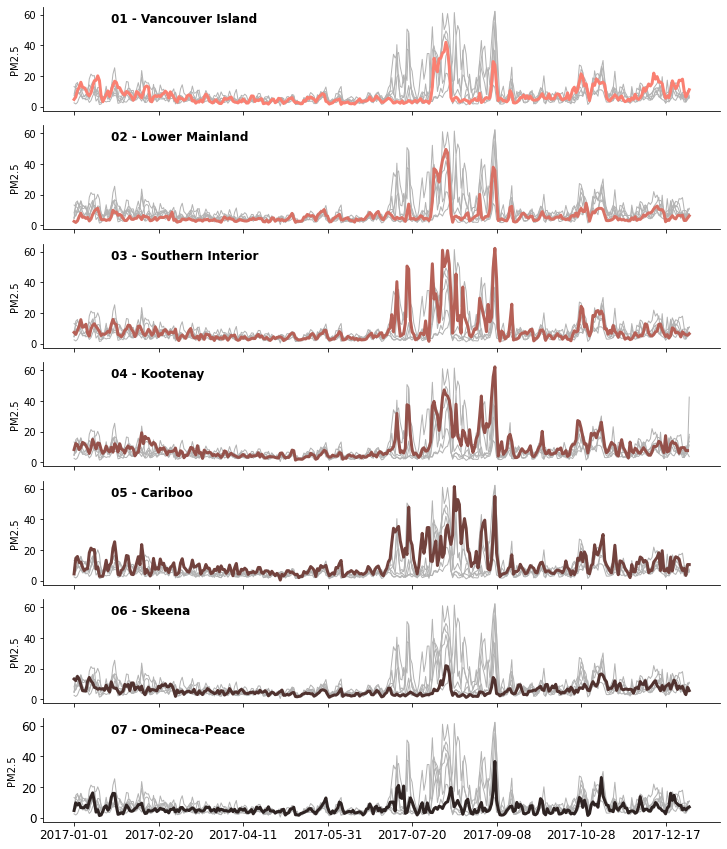

In [27]:
# Plotting percentile cleaned aggregated 2017 dataset
plot_ts(data = datasets['PM25_2017_CLEAN-P_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

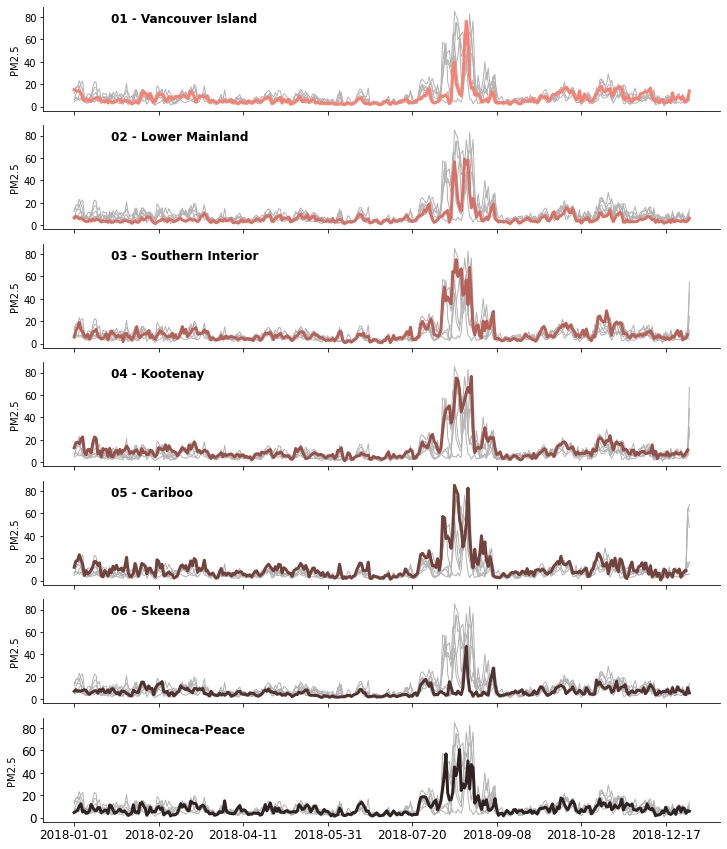

In [28]:
# Plotting percentile cleaned aggregated 2018 dataset
plot_ts(data = datasets['PM25_2018_CLEAN-P_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

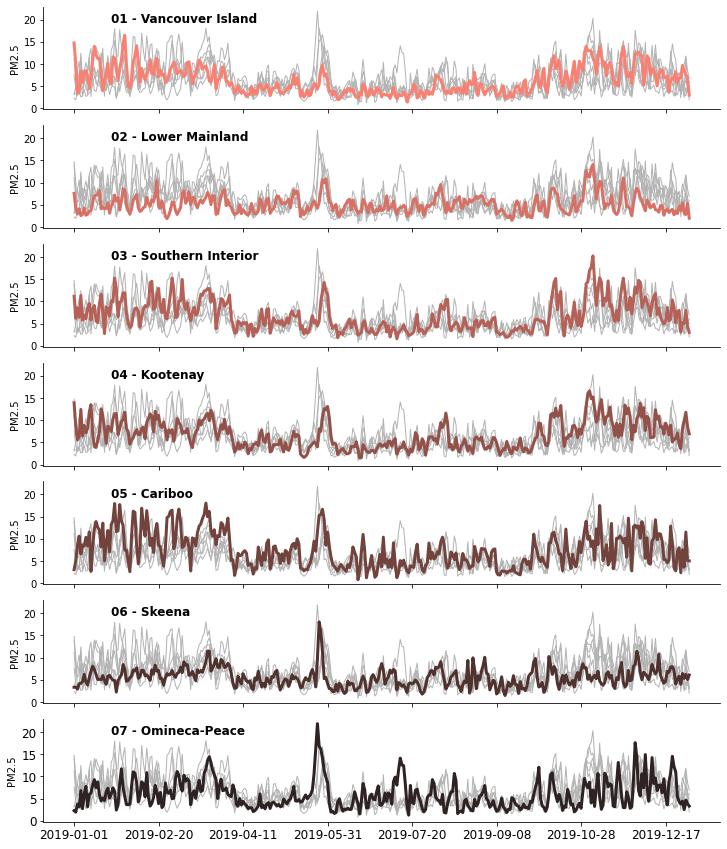

In [29]:
# Plotting percentile cleaned aggregated 2019 dataset
plot_ts(data = datasets['PM25_2019_CLEAN-P_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

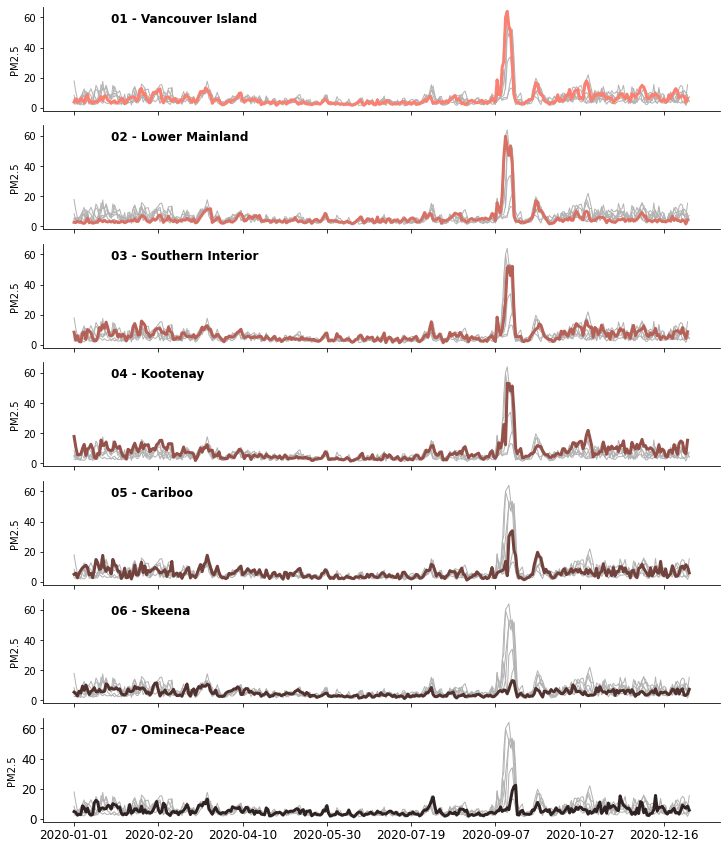

In [30]:
# Plotting percentile cleaned aggregated 2020 dataset
plot_ts(data = datasets['PM25_2020_CLEAN-P_AGG'], date = 'DATE', value = 'RAW_VALUE',
        value_label = 'PM2.5', subset = 'REGION',
        height = 1.7, aspect = 6)

## Subsetting study data
Vancouver Island stations to study:

* Vancouver Clark Drive
* Vancouver International Airport
* Vancouver North Vancouver Mahon Park
* Vancouver North Vancouver Second Narrows

In [36]:
stations = ['Vancouver Clark Drive',
            'Vancouver International Airport #2',
            'North Vancouver Mahon Park',
            'North Vancouver Second Narrows']

In [37]:
for dataset in datasets_list:
  print(dataset)
  for station in stations:
    if station not in datasets[dataset]['STATION_NAME'].unique():
      print(f"Not found: Station {station}")
    else:
      print(f"Found: Station {station}")

PM25_2016
Found: Station Vancouver Clark Drive
Found: Station Vancouver International Airport #2
Found: Station North Vancouver Mahon Park
Found: Station North Vancouver Second Narrows
PM25_2017
Found: Station Vancouver Clark Drive
Found: Station Vancouver International Airport #2
Found: Station North Vancouver Mahon Park
Found: Station North Vancouver Second Narrows
PM25_2018
Found: Station Vancouver Clark Drive
Found: Station Vancouver International Airport #2
Found: Station North Vancouver Mahon Park
Found: Station North Vancouver Second Narrows
PM25_2019
Found: Station Vancouver Clark Drive
Found: Station Vancouver International Airport #2
Found: Station North Vancouver Mahon Park
Found: Station North Vancouver Second Narrows
PM25_2020
Found: Station Vancouver Clark Drive
Found: Station Vancouver International Airport #2
Found: Station North Vancouver Mahon Park
Found: Station North Vancouver Second Narrows
PM25_2021
Found: Station Vancouver Clark Drive
Found: Station Vancouver Int

In [83]:
# Concatenating into master datasets
columns = ['DATE_PST', 'RAW_VALUE']
master_dfs = {}

for station in stations:
  master_dfs[station] = []
  for dataset in datasets_list:
    subset = datasets[dataset][columns][datasets[dataset]['STATION_NAME'] == station]
    start = min(subset['DATE_PST'])
    end = max(subset['DATE_PST'])
    # Assert time series integrity
    assert len(pd.date_range(start = start, end = end, freq = 'H')) == subset.shape[0]
    print(f"Appending subset for {station} station from {dataset}...")
    master_dfs[station].append(subset)
  master_dfs[station] = pd.concat(master_dfs[station])
  master_dfs[station].reset_index(drop = True, inplace = True)

Appending subset for Vancouver Clark Drive station from PM25_2016...
Appending subset for Vancouver Clark Drive station from PM25_2017...
Appending subset for Vancouver Clark Drive station from PM25_2018...
Appending subset for Vancouver Clark Drive station from PM25_2019...
Appending subset for Vancouver Clark Drive station from PM25_2020...
Appending subset for Vancouver Clark Drive station from PM25_2021...
Appending subset for Vancouver International Airport #2 station from PM25_2016...
Appending subset for Vancouver International Airport #2 station from PM25_2017...
Appending subset for Vancouver International Airport #2 station from PM25_2018...
Appending subset for Vancouver International Airport #2 station from PM25_2019...
Appending subset for Vancouver International Airport #2 station from PM25_2020...
Appending subset for Vancouver International Airport #2 station from PM25_2021...
Appending subset for North Vancouver Mahon Park station from PM25_2016...
Appending subset for

In [92]:
# Missing values count per dataset
for dataset in master_dfs.keys():
  missing = sum(master_dfs[dataset]['RAW_VALUE'].isna())
  pct_missing = missing / master_dfs[dataset].shape[0] * 100
  print(f"{missing} ({pct_missing:.2f} %) missing values for {dataset}")

1520 (2.67 %) missing values for Vancouver Clark Drive
547 (0.96 %) missing values for Vancouver International Airport #2
633 (1.11 %) missing values for North Vancouver Mahon Park
2251 (3.95 %) missing values for North Vancouver Second Narrows


In [91]:
# Writing master datasets csv
for dataset in master_dfs.keys():
  master_dfs[dataset].to_csv(f"output/{dataset.replace(' ', '_')}.csv", index = False)

shutil.make_archive("output", "zip", 'output/')

'/content/output.zip'